In [7]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import sys
sys.path.append('Scripts/')
from measles_simulator import *
from measles_PALSMC import *

In [10]:
#############################################
# Load the data
#############################################
UKbirths_array = np.load("Data/UKbirths_array.npy")
UKpop_array = np.load("Data/UKpop_array.npy")
measles_distance_matrix_array = np.load("Data/measles_distance_matrix_array.npy")
UKmeasles_array = np.load("Data/UKmeasles_array.npy")

UKbirths = tf.convert_to_tensor(UKbirths_array, dtype = tf.float32)
UKpop = tf.convert_to_tensor(UKpop_array, dtype = tf.float32)
measles_distance_matrix = tf.convert_to_tensor(measles_distance_matrix_array, dtype = tf.float32)
UKmeasles = tf.convert_to_tensor(UKmeasles_array, dtype = tf.float32)

term   = tf.convert_to_tensor([6, 99, 115, 198, 252, 299, 308, 355, 366], dtype = tf.float32)
school = tf.convert_to_tensor([0, 1, 0, 1, 0, 1, 0, 1, 0], dtype = tf.float32)

n_cities = tf.constant(40, dtype = tf.int64)

initial_pop = UKpop[:,0]


# Simulate from the measles model

In [12]:
T = 390
intermediate_steps = 4
is_school_term_array, is_start_school_year_array, times_total, times_obs = school_term_and_school_year(T, intermediate_steps, term, school)

is_school_term_array = tf.convert_to_tensor(is_school_term_array, dtype = tf.float32)
is_start_school_year_array = tf.convert_to_tensor(is_start_school_year_array, dtype = tf.float32)

pi_0_1 = 0.015
pi_0_2 = 0.0002
pi_0_3 = 0.0002
pi_0 = tf.convert_to_tensor([[pi_0_1, pi_0_2, pi_0_3, 1 - pi_0_1 - pi_0_2 - pi_0_3]], dtype = tf.float32)*tf.ones((n_cities, 4), dtype = tf.float32)

initial_pop = UKpop[:,0]

beta_bar  = tf.convert_to_tensor(np.random.normal(10, 2, (n_cities,1)), dtype = tf.float32)
rho   = tf.convert_to_tensor([[1/10]], dtype = tf.float32)*tf.ones((n_cities, 1), dtype = tf.float32)
gamma = tf.convert_to_tensor([[1/10]], dtype = tf.float32)*tf.ones((n_cities, 1), dtype = tf.float32)

g = tf.convert_to_tensor([[10000]], dtype = tf.float32)*tf.ones((n_cities, 1), dtype = tf.float32) 
p = tf.constant(0.759, dtype = tf.float32)
a = tf.constant(0.3,   dtype = tf.float32)
c = tf.constant(0.5,   dtype = tf.float32)

Xi = tfp.distributions.Gamma(concentration = 5, rate = 5)
Q  = tfp.distributions.TruncatedNormal( 0.7, 0.2, 0, 1)

delta_year = tf.convert_to_tensor([[1/50]], dtype = tf.float32)*tf.ones((n_cities, 4), dtype = tf.float32)

In [13]:
T_small = tf.constant(150, dtype = tf.float32)

X_t, Y_t, Xi_t, Q_t = run(T_small, intermediate_steps, UKbirths, UKpop, g, measles_distance_matrix, initial_pop, pi_0, beta_bar, p, a, is_school_term_array, is_start_school_year_array, h, rho, gamma, Xi, Q, c, n_cities, delta_year)

we can plot the data on city 29,30,31

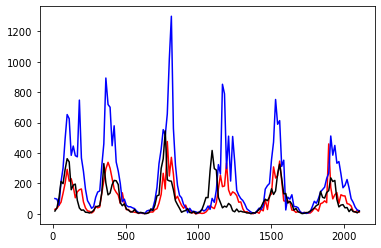

In [14]:
max_time = 150
max_value = 500
city = 29

intermediate_steps = 4

plt.plot(times_obs[:max_time], Y_t[1:(max_time+1),city,0], "red")
plt.plot(times_obs[:max_time], Y_t[1:(max_time+1),city+1,0], "blue")
plt.plot(times_obs[:max_time], Y_t[1:(max_time+1),city+2,0], "black")

# Optimize the parameters

We have 3 models: A with all shared parameters, B with city specific initial distribution and C with city specifi initial distribution and transmission rate. The training of these models might be computationally intensive, we report the trained parameters in the Data folder and the scripts to run the experiments in the following three cells.

In [16]:
T = 390
intermediate_steps = 4
is_school_term_array, is_start_school_year_array, times_total, times_obs = school_term_and_school_year(T, intermediate_steps, term, school)

is_school_term_array = tf.convert_to_tensor(is_school_term_array, dtype = tf.float32)
is_start_school_year_array = tf.convert_to_tensor(is_start_school_year_array, dtype = tf.float32)

intermediate_steps = tf.constant(4, dtype = tf.float32)
h = tf.constant(14/tf.cast(intermediate_steps, dtype = tf.float32), dtype = tf.float32)
T = tf.constant(389, dtype = tf.float32)

delta_year = tf.convert_to_tensor([[1/50]], dtype = tf.float32)*tf.ones((n_cities, 4), dtype = tf.float32)

p      = tf.constant(0.739, dtype = tf.float32)
q_mean = tf.constant(np.mean(np.load("Data/q_mean.npy")), dtype = tf.float32)


Model A

In [31]:
# # Load initial conditions
# x_0 = np.load("Data/X_0.npy")

# n_particles = 5000

# def optimization_func(x_optim):
    
#     if x_optim[0]>0 or x_optim[1]>0 or x_optim[2]>0 or x_optim[7]>(-np.log(2)-np.log(p.numpy())) or x_optim[8]>0 or x_optim[10]>1:
#         return 200000

#     x = np.exp(x_optim) 

#     if (1 - x[0] - x[1] - x[2])<0:
#         return 200000
 
#     pi_0_init = np.array([x[0], x[1], x[2], 1 - x[0] - x[1] - x[2]], dtype = np.float32)

#     beta_bar_init = tf.convert_to_tensor([x[3:4]], dtype = tf.float32)
#     rho_init = tf.convert_to_tensor([x[4:5]], dtype = tf.float32)
#     gamma_init = tf.convert_to_tensor([x[5:6]], dtype = tf.float32)
#     g_init = 100*tf.convert_to_tensor([x[6:7]], dtype = tf.float32)
#     a_init = tf.convert_to_tensor(x[7], dtype = tf.float32)
#     c_init = tf.convert_to_tensor(x[8], dtype = tf.float32)
#     xi_var = 10*tf.convert_to_tensor(x[9], dtype = tf.float32)
#     q_var  = tf.convert_to_tensor(x[10], dtype = tf.float32)
    
#     pi_0_init_transform     = pi_0_init*tf.ones((n_cities, 4), dtype = tf.float32)
#     beta_bar_init_transform = beta_bar_init*tf.ones((n_cities, 1), dtype = tf.float32)
#     rho_init_transform      = rho_init*tf.ones((n_cities, 1), dtype = tf.float32)
#     gamma_init_transform    = gamma_init*tf.ones((n_cities, 1), dtype = tf.float32)
#     g_init_transform        = g_init*tf.ones((n_cities, 1), dtype = tf.float32)

#     Xi = tfp.distributions.Gamma(concentration = xi_var, rate = xi_var)
#     Q  = tfp.distributions.TruncatedNormal( q_mean, q_var, 0, 1)

#     # The foloowing is running the lookahead, if you want to using a vanilla SMC use PAL_run_likelihood_res
#     value =  -(PAL_run_likelihood_lookahead(T, intermediate_steps, UKmeasles, UKbirths, UKpop, g_init_transform, measles_distance_matrix, initial_pop, pi_0_init_transform, beta_bar_init_transform, p, a_init, is_school_term_array, is_start_school_year_array, h, rho_init_transform, gamma_init_transform, Xi, Q, c_init, n_cities, n_particles, delta_year))[0].numpy()

#     print(value)
#     return value

# # Minimize the objective function subject to the constraints
# bnds = ((-20, -0.5), (-20, -0.5), (-20, -0.5), (-5, 5), (-4, 0), (-4, 0), (-1, 5), (-20, -np.log(2)-np.log(p)), (-20, -0.01), (-10, 3), (-10, -0.1))

# initial_loss = optimization_func(x_0)

# bnds = ((-20, -0.5), (-20, -0.5), (-20, -0.5), (-5, 5), (-4, 0), (-4, 0), (-1, 5), (-20, -np.log(2)-np.log(p)), (-20, -0.01), (-10, 3), (-10, -0.1))

# # Minimize the objective function subject to the constraints
# res = minimize(optimization_func, x_0, bounds = bnds, method='SLSQP', options ={"eps":0.5, "maxiter":100})

# final_parameters_lookahead_A = res.x 



Model B

In [34]:
# optimal_shared_param = np.load("Data/final_parameters_arraylookahead.npy")

# x_initial = optimal_shared_param[:3]
# x_initial = np.transpose(np.expand_dims(x_initial, axis =-1)*np.ones((1, n_cities)))
# x_initial[:,2] = np.log(1e-8 + UKmeasles[:,0]/initial_pop)
# x_initial = tf.reshape(x_initial, (n_cities*3))
# x_beta = optimal_shared_param[3:4]
# x_rest = optimal_shared_param[4:]

# x_to_start = np.concatenate((x_initial, x_beta, x_rest))

# n_particles = 5000

# eps_num = 0.5

# def optimization_func(x_optim):
    

#     x = np.exp(x_optim) 

#     x_initial = np.reshape(x[0:n_cities.numpy()*3], (n_cities, 3))
#     pi_0_init = tf.convert_to_tensor(np.concatenate((x_initial[:,0:1], x_initial[:,1:2], x_initial[:,2:3], 1 - x_initial[:,0:1] - x_initial[:,1:2] - x_initial[:,2:3]), axis = 1), dtype = np.float32)

#     x_beta = x[n_cities.numpy()*3:n_cities.numpy()*3+1]*np.ones((n_cities, 1))
#     beta_bar_init = tf.convert_to_tensor(np.reshape(x_beta, (n_cities, 1)), dtype = tf.float32)

#     x_rest = x[n_cities.numpy()*3+1:]
#     rho_init   = tf.convert_to_tensor([x_rest[0:1]], dtype = tf.float32)
#     gamma_init = tf.convert_to_tensor([x_rest[1:2]], dtype = tf.float32)
#     g_init = 100*tf.convert_to_tensor([x_rest[2:3]], dtype = tf.float32)
#     a_init     = tf.convert_to_tensor( x_rest[3], dtype = tf.float32)
#     c_init     = tf.convert_to_tensor( x_rest[4], dtype = tf.float32)
#     xi_var  = 10*tf.convert_to_tensor( x_rest[5], dtype = tf.float32)
#     q_var      = tf.convert_to_tensor( x_rest[6], dtype = tf.float32)
    
#     pi_0_init_transform     = pi_0_init
#     beta_bar_init_transform = beta_bar_init
#     rho_init_transform      = rho_init*tf.ones((n_cities, 1), dtype = tf.float32)
#     gamma_init_transform    = gamma_init*tf.ones((n_cities, 1), dtype = tf.float32)
#     g_init_transform        = g_init*tf.ones((n_cities, 1), dtype = tf.float32)

#     Xi = tfp.distributions.Gamma(concentration = xi_var, rate = xi_var)
#     Q  = tfp.distributions.TruncatedNormal( q_mean, q_var, 0, 1)

#     # as above
#     value =  -(PAL_run_likelihood_lookahead(T-1, intermediate_steps, UKmeasles, UKbirths, UKpop, g_init_transform, measles_distance_matrix, initial_pop, pi_0_init_transform, beta_bar_init_transform, p, a_init, is_school_term_array, is_start_school_year_array, h, rho_init_transform, gamma_init_transform, Xi, Q, c_init, n_cities, n_particles, delta_year))[0].numpy()
    
#     print(value)
#     return value

# # Minimize the objective function subject to the constraints
# bnds_x_0 = (((-20, -0.5),)*n_cities.numpy()*3)
# bnds_beta = (((-10, 10),))
# bnds_rest = ((-4, 0), (-4, 0), (-1, 5), (-20, -np.log(2)-np.log(p)), (-20, -0.01), (-10, 3), (-10, -0.1))
# bnds = bnds_x_0+bnds_beta+bnds_rest

# x_0 = x_to_start

# # Minimize the objective function subject to the constraints
# res = minimize(optimization_func, x_0, bounds = bnds, method='SLSQP', options ={"eps":eps_num, "maxiter":200})

# final_parameters_lookahead_B = res.x 


Model C

In [36]:
# optimal_shared_param = np.load("Data/final_parameters_arraylookahead.npy")

# x_initial = optimal_shared_param[:3]
# x_initial = np.transpose(np.expand_dims(x_initial, axis =-1)*np.ones((1, n_cities)))
# x_initial[:,2] = np.log(1e-8 + UKmeasles[:,0]/initial_pop)
# x_initial = tf.reshape(x_initial, (n_cities*3))
# x_beta = optimal_shared_param[3:4]*np.ones((n_cities))
# x_rest = optimal_shared_param[4:]

# x_to_start = np.concatenate((x_initial, x_beta, x_rest))

# n_particles = 5000

# eps_num = 0.5

# def optimization_func(x_optim):
    

#     x = np.exp(x_optim) 

#     x_initial = np.reshape(x[0:n_cities.numpy()*3], (n_cities, 3))
#     pi_0_init = tf.convert_to_tensor(np.concatenate((x_initial[:,0:1], x_initial[:,1:2], x_initial[:,2:3], 1 - x_initial[:,0:1] - x_initial[:,1:2] - x_initial[:,2:3]), axis = 1), dtype = np.float32)

#     x_beta = x[(n_cities.numpy()*3):(n_cities.numpy()*3+n_cities.numpy())]
#     beta_bar_init = tf.convert_to_tensor(np.reshape(x_beta, (n_cities, 1)), dtype = tf.float32)

#     x_rest = x[(n_cities.numpy()*3+n_cities.numpy()):]
#     rho_init   = tf.convert_to_tensor([x_rest[0:1]], dtype = tf.float32)
#     gamma_init = tf.convert_to_tensor([x_rest[1:2]], dtype = tf.float32)
#     g_init = 100*tf.convert_to_tensor([x_rest[2:3]], dtype = tf.float32)
#     a_init     = tf.convert_to_tensor( x_rest[3], dtype = tf.float32)
#     c_init     = tf.convert_to_tensor( x_rest[4], dtype = tf.float32)
#     xi_var  = 10*tf.convert_to_tensor( x_rest[5], dtype = tf.float32)
#     q_var      = tf.convert_to_tensor( x_rest[6], dtype = tf.float32)
    
#     pi_0_init_transform     = pi_0_init
#     beta_bar_init_transform = beta_bar_init
#     rho_init_transform      = rho_init*tf.ones((n_cities, 1), dtype = tf.float32)
#     gamma_init_transform    = gamma_init*tf.ones((n_cities, 1), dtype = tf.float32)
#     g_init_transform        = g_init*tf.ones((n_cities, 1), dtype = tf.float32)

#     Xi = tfp.distributions.Gamma(concentration = xi_var, rate = xi_var)
#     Q  = tfp.distributions.TruncatedNormal( q_mean, q_var, 0, 1)

#     # same as above
#     value =  -(PAL_run_likelihood_lookahead(T-1, intermediate_steps, UKmeasles, UKbirths, UKpop, g_init_transform, measles_distance_matrix, initial_pop, pi_0_init_transform, beta_bar_init_transform, p, a_init, is_school_term_array, is_start_school_year_array, h, rho_init_transform, gamma_init_transform, Xi, Q, c_init, n_cities, n_particles, delta_year))[0].numpy()
    
#     print(value)

#     return value

# # Minimize the objective function subject to the constraints
# bnds_x_0 = (((-20, -0.5),)*n_cities.numpy()*3)
# bnds_beta = (((-10, 10),)*n_cities.numpy())
# bnds_rest = ((-4, 0), (-4, 0), (-1, 5), (-20, -np.log(2)-np.log(p)), (-20, -0.01), (-10, 3), (-10, -0.1))
# bnds = bnds_x_0+bnds_beta+bnds_rest

# x_0 = x_to_start 

# # Minimize the objective function subject to the constraints
# res = minimize(optimization_func, x_0, bounds = bnds, method='SLSQP', options ={"eps":eps_num, "maxiter":200})

# final_parameters_lookahead_C = res.x 



## Estimate the log-likelihood variance

In [47]:
# increase the n_experiments for proper variance estimates, use n_experiments to just test the log-likelihood
n_experiments = 1

# lookahead
# shared

best_parameters = np.load("Data/Parameter/final_parameters_lookahead_A.npy")
best_parameters = np.ndarray.astype(best_parameters, dtype = np.float32)

n_cities = tf.constant(40, dtype = tf.int64)

pi_0_1 = best_parameters[0]
pi_0_2 = best_parameters[1] 
pi_0_3 = best_parameters[2] 
pi_0 = tf.convert_to_tensor([[pi_0_1, pi_0_2, pi_0_3, 1 - pi_0_1 - pi_0_2 - pi_0_3]], dtype = tf.float32)*tf.ones((n_cities, 4), dtype = tf.float32)

initial_pop = UKpop[:,0]

beta_bar  = tf.convert_to_tensor((best_parameters[3])*tf.ones((n_cities,1)), dtype = tf.float32)
rho   = tf.convert_to_tensor([[best_parameters[4]]], dtype = tf.float32)*tf.ones((n_cities, 1), dtype = tf.float32)
gamma = tf.convert_to_tensor([[best_parameters[5]]], dtype = tf.float32)*tf.ones((n_cities, 1), dtype = tf.float32)

g = tf.convert_to_tensor([[float(100)*best_parameters[6]]], dtype = tf.float32)*tf.ones((n_cities, 1), dtype = tf.float32) 
a = tf.constant(best_parameters[7],   dtype = tf.float32)
c = tf.constant(best_parameters[8],   dtype = tf.float32)
xi_var = 10*tf.convert_to_tensor(best_parameters[9], dtype = tf.float32)
q_var  = tf.convert_to_tensor(best_parameters[10], dtype = tf.float32)


Xi = tfp.distributions.Gamma(concentration = xi_var, rate = xi_var)
Q  = tfp.distributions.TruncatedNormal( q_mean, q_var, 0, 1)

n_particles = 1000
log_likelihood_shared = np.zeros(n_experiments)

for i in tf.range(n_experiments):

    value = (PAL_run_likelihood_lookahead(T-1, intermediate_steps, UKmeasles, UKbirths, UKpop, g, measles_distance_matrix, initial_pop, pi_0, beta_bar, p, a, is_school_term_array, is_start_school_year_array, h, rho, gamma, Xi, Q, c, n_cities, n_particles, delta_year))[0].numpy()

    log_likelihood_shared[i] = value

    print(value)

# initial distribution city specific
best_parameters = np.load("Data/Parameter/final_parameters_lookahead_B.npy")
best_parameters = np.ndarray.astype(best_parameters, dtype = np.float32)

x = best_parameters

x_initial = np.reshape(x[0:n_cities.numpy()*3], (n_cities, 3))
pi_0_init = tf.convert_to_tensor(np.concatenate((x_initial[:,0:1], x_initial[:,1:2], x_initial[:,2:3], 1 - x_initial[:,0:1] - x_initial[:,1:2] - x_initial[:,2:3]), axis = 1), dtype = np.float32)

x_beta = x[n_cities.numpy()*3:n_cities.numpy()*3+1]*np.ones((n_cities))
beta_bar_init = tf.convert_to_tensor(np.reshape(x_beta, (n_cities, 1)), dtype = tf.float32)

x_rest = x[n_cities.numpy()*3+1:]
rho_init   = tf.convert_to_tensor([x_rest[0:1]], dtype = tf.float32)
gamma_init = tf.convert_to_tensor([x_rest[1:2]], dtype = tf.float32)
g_init = 100*tf.convert_to_tensor([x_rest[2:3]], dtype = tf.float32)
a     = tf.convert_to_tensor( x_rest[3], dtype = tf.float32)
c     = tf.convert_to_tensor( x_rest[4], dtype = tf.float32)
xi_var  = 10*tf.convert_to_tensor( x_rest[5], dtype = tf.float32)
q_var      = tf.convert_to_tensor( x_rest[6], dtype = tf.float32)

pi_0     = pi_0_init
beta_bar = beta_bar_init
rho      = rho_init*tf.ones((n_cities, 1), dtype = tf.float32)
gamma    = gamma_init*tf.ones((n_cities, 1), dtype = tf.float32)
g        = g_init*tf.ones((n_cities, 1), dtype = tf.float32)

Xi = tfp.distributions.Gamma(concentration = xi_var, rate = xi_var)
Q  = tfp.distributions.TruncatedNormal( q_mean, q_var, 0, 1)

log_likelihood_specific_initial = np.zeros(n_experiments)

for i in tf.range(n_experiments):

    value = (PAL_run_likelihood_lookahead(T-1, intermediate_steps, UKmeasles, UKbirths, UKpop, g, measles_distance_matrix, initial_pop, pi_0, beta_bar, p, a, is_school_term_array, is_start_school_year_array, h, rho, gamma, Xi, Q, c, n_cities, n_particles, delta_year))[0].numpy()

    log_likelihood_specific_initial[i] = value

    print(value)

# beta param city specific
best_parameters = np.load("Data/Parameter/final_parameters_lookahead_C.npy")
best_parameters = np.ndarray.astype(best_parameters, dtype = np.float32)

x = best_parameters

x_initial = np.reshape(x[0:n_cities.numpy()*3], (n_cities, 3))
pi_0 = tf.convert_to_tensor(np.concatenate((x_initial[:,0:1], x_initial[:,1:2], x_initial[:,2:3], 1 - x_initial[:,0:1] - x_initial[:,1:2] - x_initial[:,2:3]), axis = 1), dtype = np.float32)

x_beta = x[(n_cities.numpy()*3):(n_cities.numpy()*3+n_cities.numpy())]
beta_bar = tf.convert_to_tensor(np.reshape(x_beta, (n_cities, 1)), dtype = tf.float32)

x_rest = x[(n_cities.numpy()*3+n_cities.numpy()):]
rho   = tf.convert_to_tensor([x_rest[0:1]], dtype = tf.float32)
gamma = tf.convert_to_tensor([x_rest[1:2]], dtype = tf.float32)
g = 100*tf.convert_to_tensor([x_rest[2:3]], dtype = tf.float32)
a     = tf.convert_to_tensor( x_rest[3], dtype = tf.float32)
c     = tf.convert_to_tensor( x_rest[4], dtype = tf.float32)
xi_var  = 10*tf.convert_to_tensor( x_rest[5], dtype = tf.float32)
q_var      = tf.convert_to_tensor( x_rest[6], dtype = tf.float32)

pi_0     = pi_0
beta_bar = beta_bar
rho      = rho*tf.ones((n_cities, 1), dtype = tf.float32)
gamma    = gamma*tf.ones((n_cities, 1), dtype = tf.float32)
g        = g*tf.ones((n_cities, 1), dtype = tf.float32)

Xi = tfp.distributions.Gamma(concentration = xi_var, rate = xi_var)
Q  = tfp.distributions.TruncatedNormal( q_mean, q_var, 0, 1)

log_likelihood_specific = np.zeros(n_experiments)

for i in tf.range(n_experiments):

    value = (PAL_run_likelihood_lookahead(T-1, intermediate_steps, UKmeasles, UKbirths, UKpop, g, measles_distance_matrix, initial_pop, pi_0, beta_bar, p, a, is_school_term_array, is_start_school_year_array, h, rho, gamma, Xi, Q, c, n_cities, n_particles, delta_year))[0].numpy()

    log_likelihood_specific[i] = value

    print(value)


-58753.848
-56951.113
-56834.61


In [48]:
loglikelihoo_lookahead_shared           = np.load("Data/loglikelihood_lookahead_shared.npy")
loglikelihoo_lookahead_specific         = np.load("Data/loglikelihood_lookahead_specific.npy")
loglikelihoo_lookahead_specific_initial = np.load("Data/loglikelihood_lookahead_specific_initial.npy")

loglikelihoo_lookahead = [loglikelihoo_lookahead_shared, loglikelihoo_lookahead_specific_initial, loglikelihoo_lookahead_specific, ]

Text(0, 0.5, 'Log-likelihood')

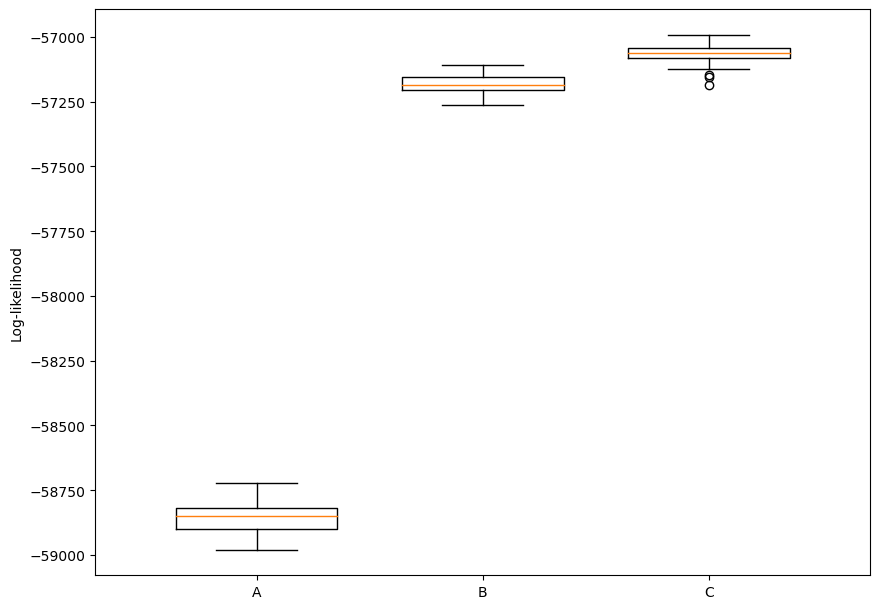

In [49]:
# Set up the figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 7.5), dpi = 100)

position = [1, 1.7, 2.4]

# Plot the boxplots for each group, closer together
ax.boxplot(loglikelihoo_lookahead, positions = position, widths = 0.5)
ax.set_xticklabels([r'A', r'B', r'C',], )
ax.tick_params(axis="y", )
ax.set_ylabel("Log-likelihood", )